# PYTHON CODE to the paper "LLMs are not Weird"

# A. Descriptive Statistics and Dendrograms

In [1]:
# ============================================================
# 1) Split rows into Countries (ID==1) and LLMs (ID==0)
# 2) Descriptive stats per group (CSV)
# 3) Correlation heatmaps per group (PNG)
# 4) Combined dendrograms (Euclidean + Correlation) in one 2x1 figure
#
# Output dir: Submission 3_outputs/
# ============================================================

from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram


# ---------- configuration ----------
@dataclass(frozen=True)
class CFG:
    xlsx_path: Path = Path("Submission_3_Main_v0.xlsx")
    sheet_name: str | int | None = 0
    id_col: str = "ID"   # 1=countries, 0=LLMs
    outdir: Path = Path("Submission 3_outputs")
    linkage: str = "average"
    metrics: tuple = ("Euclidean", "Correlation")
    random_state: int = 42


CFG = CFG()
CFG.outdir.mkdir(parents=True, exist_ok=True)


# ---------- helpers ----------
def load_data(xlsx_path: Path, sheet):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    df.columns = [str(c).strip() for c in df.columns]
    return df


def guess_name_col(df: pd.DataFrame, id_col: str) -> str | None:
    preferred = {"Name", "Country", "Entity", "Label"}
    for c in df.columns:
        if c in preferred:
            return c
    for c in df.columns:
        if c != id_col and pd.api.types.is_string_dtype(df[c]):
            return c
    return None


def get_feature_cols(df: pd.DataFrame, exclude_cols: list[str]) -> list[str]:
    return [c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]


def describe_group(df: pd.DataFrame, feature_cols: list[str], label: str, outdir: Path):
    desc = df[feature_cols].describe()
    desc = desc.drop(["25%", "75%"], axis=0)
    desc = desc.rename(index={"50%": "median"})
    desc = desc.round(1)
    desc.to_csv(outdir / f"descriptive_stats_{label}.csv", index=True)
    return desc


def plot_corr_heatmap(df: pd.DataFrame, feature_cols: list[str], label: str, outdir: Path):
    corr = df[feature_cols].corr(method="pearson")
    fig_h = max(6, 0.4 * len(feature_cols))
    fig_w = max(8, 0.5 * len(feature_cols))
    plt.figure(figsize=(fig_w, fig_h))
    sns.heatmap(corr, cmap="vlag", center=0, annot=False, square=True)
    plt.title(f"Correlation heatmap: {label}")
    plt.tight_layout()
    plt.savefig(outdir / f"corr_heatmap_{label}.png", dpi=300)
    plt.close()


def standardize_and_impute(df: pd.DataFrame, feature_cols: list[str]) -> tuple[np.ndarray, np.ndarray]:
    mask_valid = ~df[feature_cols].isna().all(axis=1)
    X = df.loc[mask_valid, feature_cols].to_numpy(dtype=float)
    Xi = SimpleImputer(strategy="median").fit_transform(X)
    Xs = StandardScaler().fit_transform(Xi)
    return Xs, mask_valid


def plot_dendrogram(Xs: np.ndarray, names: list[str], ids: list[int],
                    metric: str, linkage_method: str, ax):
    llm_color = "red"

    if metric == "Euclidean":
        Z = linkage(Xs, method=linkage_method, metric="Euclidean", optimal_ordering=True)
        threshold = 5
        dendro = dendrogram(Z, color_threshold=threshold, labels=names, leaf_rotation=90, ax=ax)

        # --- recolor LLM branches red manually ---
        icoords = dendro["icoord"]
        dcoords = dendro["dcoord"]
        color_list = dendro["color_list"]
        leaf_order = dendro["leaves"]

        llm_leaves = [i for i, idx in enumerate(leaf_order) if ids[idx] == 0]
        llm_leaves_set = set(llm_leaves)

        for xs, ys, color in zip(icoords, dcoords, color_list):
            x_positions = np.array(xs[1:3])
            leaf_indices = np.round((x_positions - 5.0) / 10.0).astype(int)
            if all(i in llm_leaves_set for i in leaf_indices):
                ax.plot(xs, ys, color=llm_color, lw=1.5)
            else:
                ax.plot(xs, ys, color=color, lw=1.0)

    else:  # Correlation dendrogram
        condensed = pdist(Xs, metric=metric)
        Z = linkage(condensed, method=linkage_method, optimal_ordering=True)
        threshold = 0.65

        # 👇 Remove red from color palette for correlation
        from matplotlib import cycler
        plt.rcParams["axes.prop_cycle"] = cycler(color=[
            "#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
        ])

        dendro = dendrogram(Z, color_threshold=threshold, labels=names, leaf_rotation=90, ax=ax)

        # --- recolor only LLM branches red ---
        icoords = dendro["icoord"]
        dcoords = dendro["dcoord"]
        color_list = dendro["color_list"]
        leaf_order = dendro["leaves"]

        llm_leaves = [i for i, idx in enumerate(leaf_order) if ids[idx] == 0]
        llm_leaves_set = set(llm_leaves)

        for xs, ys, color in zip(icoords, dcoords, color_list):
            x_positions = np.array(xs[1:3])
            leaf_indices = np.round((x_positions - 5.0) / 10.0).astype(int)
            if all(i in llm_leaves_set for i in leaf_indices):
                ax.plot(xs, ys, color=llm_color, lw=1.5)
            else:
                ax.plot(xs, ys, color=color, lw=1.0)

    # --- label formatting ---
    for lbl in ax.get_xmajorticklabels():
        name = lbl.get_text()
        idx = names.index(name)
        if ids[idx] == 0:
            lbl.set_color(llm_color)
        lbl.set_fontsize(11)
        lbl.set_fontweight("bold")
        lbl.set_rotation(90)

    ax.set_title(f"{metric}", fontsize=13)
    ax.set_xlabel("Entities", fontsize=12)
    ax.set_ylabel("Distance", fontsize=12)


# ---------- main ----------
df = load_data(CFG.xlsx_path, CFG.sheet_name)

# Convert question columns to numeric
for c in df.columns:
    if c.startswith("Question"):
        df[c] = pd.to_numeric(df[c], errors="coerce")

if CFG.id_col not in df.columns:
    raise ValueError(f"Expected '{CFG.id_col}' column not found.")

name_col = guess_name_col(df, CFG.id_col) or "_Entity"
if name_col == "_Entity":
    df[name_col] = [f"Item_{i+1}" for i in range(len(df))]

feature_cols = get_feature_cols(df, exclude_cols=[CFG.id_col, name_col])
countries = df[df[CFG.id_col] == 1].copy()
llms = df[df[CFG.id_col] == 0].copy()

describe_group(countries, feature_cols, "countries", CFG.outdir)
describe_group(llms, feature_cols, "llms", CFG.outdir)

if len(countries) >= 2:
    plot_corr_heatmap(countries, feature_cols, "countries", CFG.outdir)
if len(llms) >= 2:
    plot_corr_heatmap(llms, feature_cols, "llms", CFG.outdir)

Xs, mask_valid = standardize_and_impute(df, feature_cols)
names_all = df.loc[mask_valid, name_col].astype(str).tolist()
ids_all = df.loc[mask_valid, CFG.id_col].astype(int).tolist()

# ---------- combined dendrograms ----------
fig, axes = plt.subplots(2, 1, figsize=(max(10, 0.22 * len(names_all)), 10))
for ax, metric in zip(axes, CFG.metrics):
    plot_dendrogram(Xs, names_all, ids_all, metric, CFG.linkage, ax)

fig.suptitle(f"Hierarchical Clustering Dendrograms ({CFG.linkage} linkage)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(CFG.outdir / f"dendrogram{CFG.linkage}.png", dpi=500)
plt.savefig(CFG.outdir / f"dendrogram{CFG.linkage}.pdf",  format='pdf')

plt.close()



# B. Silhouette Scores for the Dendrograms

In [2]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

for metric in CFG.metrics:
    if metric == "euclidean":
        D = pdist(Xs, metric="euclidean")
    else:
        D = pdist(Xs, metric=metric)

    Z = linkage(D, method=CFG.linkage, optimal_ordering=True)
    D_full = squareform(D)  # <-- this converts to n×n matrix for silhouette_score

    for k in range(2, 11):
        labels = fcluster(Z, k, criterion="maxclust")
        if len(np.unique(labels)) > 1:
            sil = silhouette_score(D_full, labels, metric="precomputed")
            print(f"Metric={metric}, k={k}, silhouette={sil:.4f}")
        else:
            print(f"Metric={metric}, k={k}, silhouette=nan (single cluster)")


Metric=Euclidean, k=2, silhouette=0.6834
Metric=Euclidean, k=3, silhouette=0.5078
Metric=Euclidean, k=4, silhouette=0.4763
Metric=Euclidean, k=5, silhouette=0.4768
Metric=Euclidean, k=6, silhouette=0.4259
Metric=Euclidean, k=7, silhouette=0.4215
Metric=Euclidean, k=8, silhouette=0.4079
Metric=Euclidean, k=9, silhouette=0.4159
Metric=Euclidean, k=10, silhouette=0.4145
Metric=Correlation, k=2, silhouette=0.5237
Metric=Correlation, k=3, silhouette=0.4525
Metric=Correlation, k=4, silhouette=0.4315
Metric=Correlation, k=5, silhouette=0.4756
Metric=Correlation, k=6, silhouette=0.4819
Metric=Correlation, k=7, silhouette=0.4739
Metric=Correlation, k=8, silhouette=0.4442
Metric=Correlation, k=9, silhouette=0.4263
Metric=Correlation, k=10, silhouette=0.4340


# C. K-Means

In [3]:
#Install this if needed
#!pip install scikit-learn-extra  

# ---------- KMeans/KMedoids + silhouette + inertia + Calinski–Harabasz Index ----------
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import pdist, squareform

def run_cluster_range(Xs, metrics, outdir, k_range=range(2, 16), random_state=42):
    results = []

    marker_map = {
        "euclidean": "o",
        "correlation": "s",
    }

    for metric in metrics:
        metric_lower = metric.lower()
        for k in k_range:
            if metric_lower == "euclidean":
                model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
                labels = model.fit_predict(Xs)
                inertia = model.inertia_

                if len(np.unique(labels)) > 1:
                    sil = silhouette_score(Xs, labels, metric="euclidean")
                    chi = calinski_harabasz_score(Xs, labels)
                else:
                    sil, chi = np.nan, np.nan

            elif metric_lower == "correlation":
                D = squareform(pdist(Xs, metric="correlation"))
                model = KMedoids(n_clusters=k, metric="precomputed", random_state=random_state)
                labels = model.fit_predict(D)

                if len(np.unique(labels)) > 1:
                    sil = silhouette_score(D, labels, metric="precomputed")
                    # For Calinski–Harabasz, we need feature space, not distances
                    chi = calinski_harabasz_score(Xs, labels)
                    inertia = np.nan  # no inertia for precomputed distance
                else:
                    sil, chi, inertia = np.nan, np.nan, np.nan
            else:
                raise ValueError(f"Unsupported metric: {metric}")

            results.append({
                "metric": metric.title(),
                "metric_lower": metric_lower,
                "k": k,
                "silhouette": sil,
                "inertia": inertia,
                "calinski_harabasz": chi
            })

    df = pd.DataFrame(results)

    # --- combined subplot for silhouette and CHI ---
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    for metric in metrics:
        sub = df[df["metric"] == metric.title()]
        m = marker_map.get(metric.lower(), "o")
        axes[0].plot(sub["k"], sub["silhouette"], marker=m, markersize=1, linewidth=0.5, label=metric.title())
    axes[0].set_title("Silhouette Score (KMeans/KMedoids)")
    axes[0].set_xlabel("Number of clusters (k)")
    axes[0].set_ylabel("Silhouette score")
    axes[0].legend(fontsize=7)
    
    for metric in metrics:
        sub = df[df["metric"] == metric.title()]
        m = marker_map.get(metric.lower(), "o")
        axes[1].plot(sub["k"], sub["calinski_harabasz"], marker=m, markersize=1, linewidth=0.5, label=metric.title())
    axes[1].set_title("Calinski–Harabasz Index (KMeans/KMedoids)")
    axes[1].set_xlabel("Number of clusters (k)")
    axes[1].set_ylabel("Calinski–Harabasz score")
    axes[1].legend(fontsize=7)
    
    for ax in axes:
        ax.tick_params(labelsize=7)
        ax.title.set_fontsize(8)
        ax.xaxis.label.set_fontsize(9)
        ax.yaxis.label.set_fontsize(8)
    
    plt.tight_layout(pad=0.8, w_pad=0.5)
    plt.savefig(CFG.outdir / "silhouette_calinski.png", dpi=500, bbox_inches="tight")
    plt.close()
    print((CFG.outdir / "silhouette_calinski_combined.png").resolve())

run_cluster_range(Xs, CFG.metrics, CFG.outdir)


C:\Users\orhan\anaconda3\envs\clustering\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
C:\Users\orhan\anaconda3\envs\clustering\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\orhan\anaconda3\envs\clustering\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windo

C:\Users\orhan\Dropbox\My papers and works\LLMs are not Weird\Submissions\JBEE\Submission 3\Submission 3 Python Codes and Data\Submission 3_outputs\silhouette_calinski_combined.png


# D. Clusters

In [4]:
# 3 clusters is selected here
# ---------- Single run with chosen k ----------
metric = "euclidean" #"correlation"
X_input = Xs

# --- choose algorithm based on metric ---
if metric == "correlation":
    D = squareform(pdist(Xs, metric="correlation"))
    model = KMedoids(n_clusters=11, metric="precomputed", random_state=CFG.random_state)
    labels = model.fit_predict(D)
else:
    model = KMeans(n_clusters=3, random_state=CFG.random_state, n_init=10)     #Number of clusters is entered here. 
    labels = model.fit_predict(Xs)

# --- save cluster assignments ---
df_valid = df.loc[mask_valid].copy()
df_clusters = df_valid[[name_col]].copy()
df_clusters["Cluster"] = labels

# Pivot to one column per cluster
clusters_wide = []
for k in sorted(df_clusters["Cluster"].unique()):
    members = df_clusters.loc[df_clusters["Cluster"] == k, name_col].reset_index(drop=True)
    members.name = f"Cluster_{k}"
    clusters_wide.append(members)

# Combine all clusters side by side
df_wide = pd.concat(clusters_wide, axis=1)

# Save both versions if desired
df_wide.to_excel(CFG.outdir / "kmeans_clusters_wide.xlsx", index=False)


C:\Users\orhan\anaconda3\envs\clustering\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# E1. 2-Dimensional PCA

In [5]:
from sklearn.decomposition import PCA

def run_pca_analysis(df, feature_cols, id_col, name_col, outdir, random_state=42):
    def _pca_single(subdf, label):
        # Drop columns that are entirely NaN or constant
        valid_cols = [
            c for c in feature_cols
            if subdf[c].notna().any() and subdf[c].nunique(dropna=True) > 1
        ]
        dropped = [c for c in feature_cols if c not in valid_cols]
        if dropped:
            print(f"[{label}] Dropping {len(dropped)} constant/missing features: {dropped}")

        if len(valid_cols) < 2:
            print(f"[{label}] Not enough valid features for PCA (n={len(valid_cols)}). Skipping.")
            return None, None

        # --- preprocess ---
        Xs, mask_valid = standardize_and_impute(subdf, valid_cols)
        names = subdf.loc[mask_valid, name_col].astype(str).tolist()
        ids = subdf.loc[mask_valid, id_col].astype(int).tolist()

        # --- fit PCA ---
        pca = PCA(random_state=random_state)
        X_pca = pca.fit_transform(Xs)
        expl_var = pca.explained_variance_ratio_

        # --- print explained variance numerically ---
        print(f"\nPCA Results ({label}):")
        for i, v in enumerate(expl_var[:10]):  # only print first 10 components
            print(f"  PC{i+1}: {v*100:.2f}%")
        print(f"  Total variance explained (first {len(expl_var)} PCs): {expl_var.sum()*100:.2f}%")

        # --- save explained variance ---
        var_df = pd.DataFrame({
            "PC": [f"PC{i+1}" for i in range(len(expl_var))],
            "ExplainedVarianceRatio": expl_var,
            "ExplainedVariancePercent": expl_var * 100,
            "CumulativeVariancePercent": np.cumsum(expl_var) * 100
        })
     #   var_df.to_csv(outdir / f"pca_variance_{label}.csv", index=False)

        # --- save loadings ---
        loadings = pd.DataFrame(
            pca.components_.T,
            columns=[f"PC{i+1}" for i in range(len(expl_var))],
            index=valid_cols
        )
   #     loadings.to_csv(outdir / f"pca_loadings_{label}.csv")

        # --- scatter plot (optional but useful) ---
        if X_pca.shape[1] >= 2:
            plt.figure(figsize=(7, 5))
            for i, name in enumerate(names):
                color = "tab:orange" if ids[i] == 0 else "tab:blue"
                plt.scatter(X_pca[i, 0], X_pca[i, 1], c=color,
                            label="LLM" if ids[i] == 0 else "Country",
                            s=60, edgecolor='k', alpha=0.8)
                plt.text(X_pca[i, 0], X_pca[i, 1], name, fontsize=7,
                         ha="left", va="bottom")
            plt.title(f"PCA Scatter Plot (PC1 vs PC2): {label}")
            plt.xlabel(f"PC1 ({expl_var[0]*100:.1f}% var)")
            plt.ylabel(f"PC2 ({expl_var[1]*100:.1f}% var)")
            plt.tight_layout()
            plt.savefig(outdir / f"pca_scatter_{label}.png", dpi=300)
            plt.close()

        return var_df, loadings

    # --- Combined ---
    print("\n--- PCA: Combined Data ---")
    _pca_single(df, "combined")

    # --- Countries only ---
    print("\n--- PCA: Countries Only ---")
    _pca_single(df[df[id_col] == 1].copy(), "countries")

    # --- LLMs only ---
    print("\n--- PCA: LLMs Only ---")
    _pca_single(df[df[id_col] == 0].copy(), "llms")


# Run PCA analysis
run_pca_analysis(df, feature_cols, CFG.id_col, name_col, CFG.outdir, CFG.random_state)



--- PCA: Combined Data ---

PCA Results (combined):
  PC1: 50.99%
  PC2: 23.38%
  PC3: 7.21%
  PC4: 5.47%
  PC5: 4.88%
  PC6: 2.74%
  PC7: 2.00%
  PC8: 1.38%
  PC9: 0.77%
  PC10: 0.49%
  Total variance explained (first 14 PCs): 100.00%

--- PCA: Countries Only ---

PCA Results (countries):
  PC1: 39.82%
  PC2: 26.28%
  PC3: 9.13%
  PC4: 7.85%
  PC5: 5.19%
  PC6: 4.10%
  PC7: 3.57%
  PC8: 2.02%
  PC9: 0.75%
  PC10: 0.52%
  Total variance explained (first 14 PCs): 100.00%

--- PCA: LLMs Only ---

PCA Results (llms):
  PC1: 36.50%
  PC2: 27.83%
  PC3: 15.82%
  PC4: 6.78%
  PC5: 5.43%
  PC6: 3.52%
  PC7: 2.25%
  PC8: 1.02%
  PC9: 0.57%
  PC10: 0.16%
  Total variance explained (first 14 PCs): 100.00%


# E2. 3-Dimensional PCA


--- PCA: Combined Data ---

PCA Results (Combined):
  PC1: 50.99%
  PC2: 23.38%
  PC3: 7.21%
  PC4: 5.47%
  PC5: 4.88%
  PC6: 2.74%
  PC7: 2.00%
  PC8: 1.38%
  PC9: 0.77%
  PC10: 0.49%
  Total variance explained (first 14 PCs): 100.00%

--- PCA: Countries Only ---

PCA Results (Countries):
  PC1: 39.82%
  PC2: 26.28%
  PC3: 9.13%
  PC4: 7.85%
  PC5: 5.19%
  PC6: 4.10%
  PC7: 3.57%
  PC8: 2.02%
  PC9: 0.75%
  PC10: 0.52%
  Total variance explained (first 14 PCs): 100.00%

--- PCA: LLMs Only ---

PCA Results (LLMs):
  PC1: 36.50%
  PC2: 27.83%
  PC3: 15.82%
  PC4: 6.78%
  PC5: 5.43%
  PC6: 3.52%
  PC7: 2.25%
  PC8: 1.02%
  PC9: 0.57%
  PC10: 0.16%
  Total variance explained (first 14 PCs): 100.00%

--- Creating 1x3 PCA subplot figure ---

--- Creating 3x1 PCA subplot figure (stacked) ---


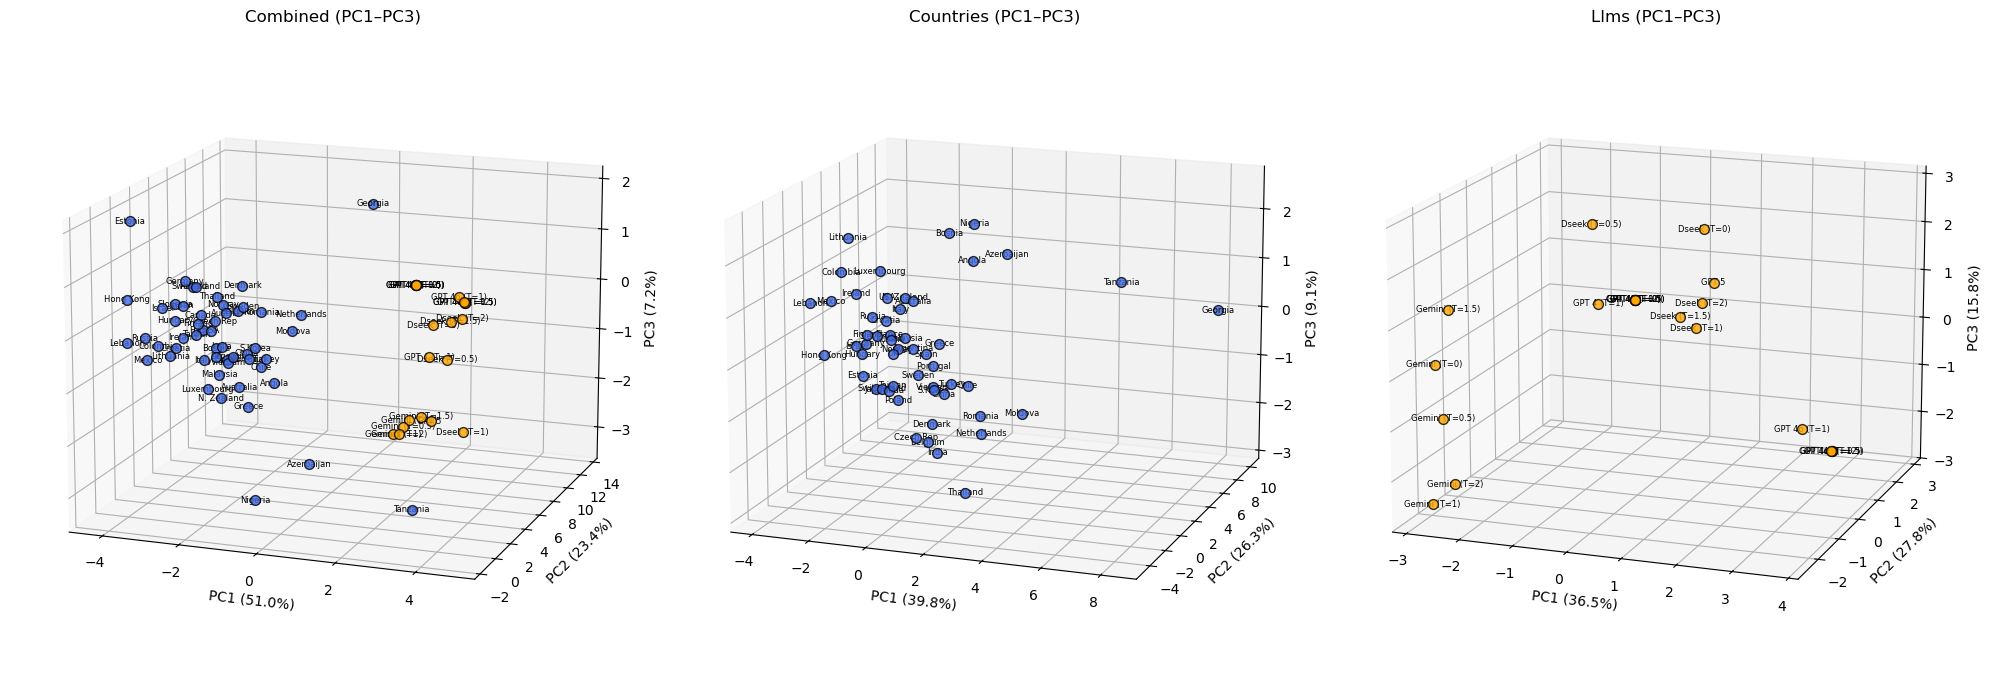

In [6]:
# ---------- PCA Analysis with 3D Visualization (with 1x3 combined plot) ----------
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D plots)

def run_pca_analysis(df, feature_cols, id_col, name_col, outdir, random_state=42):
    def _pca_single(subdf, label):
        # Drop columns that are entirely NaN or constant
        valid_cols = [
            c for c in feature_cols
            if subdf[c].notna().any() and subdf[c].nunique(dropna=True) > 1
        ]
        dropped = [c for c in feature_cols if c not in valid_cols]
        if dropped:
            print(f"[{label}] Dropping {len(dropped)} constant/missing features: {dropped}")

        if len(valid_cols) < 2:
            print(f"[{label}] Not enough valid features for PCA (n={len(valid_cols)}). Skipping.")
            return None, None

        # --- preprocess ---
        Xs, mask_valid = standardize_and_impute(subdf, valid_cols)
        names = subdf.loc[mask_valid, name_col].astype(str).tolist()
        ids = subdf.loc[mask_valid, id_col].astype(int).tolist()

        # --- fit PCA ---
        pca = PCA(random_state=random_state)
        X_pca = pca.fit_transform(Xs)
        expl_var = pca.explained_variance_ratio_

        # --- numeric output ---
        print(f"\nPCA Results ({label}):")
        for i, v in enumerate(expl_var[:10]):
            print(f"  PC{i+1}: {v*100:.2f}%")
        print(f"  Total variance explained (first {len(expl_var)} PCs): {expl_var.sum()*100:.2f}%")

        # --- save explained variance ---
        var_df = pd.DataFrame({
            "PC": [f"PC{i+1}" for i in range(len(expl_var))],
            "ExplainedVarianceRatio": expl_var,
            "ExplainedVariancePercent": expl_var * 100,
            "CumulativeVariancePercent": np.cumsum(expl_var) * 100
        })
#        var_df.to_csv(outdir / f"pca_variance_{label}.csv", index=False)

        # --- save loadings ---
        loadings = pd.DataFrame(
            pca.components_.T,
            columns=[f"PC{i+1}" for i in range(len(expl_var))],
            index=valid_cols
        )
        # loadings.to_csv(outdir / f"pca_loadings_{label}.csv")

        # --- 3D scatter plot ---
        if X_pca.shape[1] >= 3:
            fig = plt.figure(figsize=(7, 4))
            ax = fig.add_subplot(111, projection="3d")
            for i, name in enumerate(names):
                color = "orange" if ids[i] == 0 else "royalblue"
                ax.scatter(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2],
                           color=color, s=60, edgecolor='k', alpha=0.9)
                ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], name,
                        fontsize=7, ha="center", va="center")
            ax.set_title(f"PCA 3D Scatter (PC1–PC3): {label}")
            ax.set_xlabel(f"PC1 ({expl_var[0]*100:.1f}% var)")
            ax.set_ylabel(f"PC2 ({expl_var[1]*100:.1f}% var)")
            ax.set_zlabel(f"PC3 ({expl_var[2]*100:.1f}% var)")
            plt.tight_layout()
          #  plt.savefig(outdir / f"pca_scatter3d_{label}.png", dpi=500)
            plt.close()

        return var_df, loadings

    # --- Run for all three datasets ---
    print("\n--- PCA: Combined Data ---")
    _pca_single(df, "Combined")

    print("\n--- PCA: Countries Only ---")
    _pca_single(df[df[id_col] == 1].copy(), "Countries")

    print("\n--- PCA: LLMs Only ---")
    _pca_single(df[df[id_col] == 0].copy(), "LLMs")

    # --- Combined 1x3 subplot visualization ---
    print("\n--- Creating 1x3 PCA subplot figure ---")
    labels = ["Combined", "Countries", "LLMs"]
    fig = plt.figure(figsize=(20, 7))
    view_elev, view_azim = 15, -70  # Consistent 3D view

    for i, label in enumerate(labels, 1):
        # Select subset
        if label == "Countries":
            subdf = df[df[id_col] == 1].copy()
        elif label == "LLMs":
            subdf = df[df[id_col] == 0].copy()
        else:
            subdf = df.copy()

        valid_cols = [c for c in feature_cols if subdf[c].notna().any() and subdf[c].nunique(dropna=True) > 1]
        Xs, mask_valid = standardize_and_impute(subdf, valid_cols)
        names = subdf.loc[mask_valid, name_col].astype(str).tolist()
        ids = subdf.loc[mask_valid, id_col].astype(int).tolist()
        pca = PCA(random_state=random_state)
        X_pca = pca.fit_transform(Xs)
        expl_var = pca.explained_variance_ratio_

        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.view_init(elev=view_elev, azim=view_azim)
        for j, name in enumerate(names):
            color = "orange" if ids[j] == 0 else "royalblue"
            ax.scatter(X_pca[j, 0], X_pca[j, 1], X_pca[j, 2],
                       color=color, s=50, edgecolor='k', alpha=0.8)
            ax.text(X_pca[j, 0], X_pca[j, 1], X_pca[j, 2], name,
                    fontsize=6, ha='center', va='center')
        ax.set_title(f"{label.capitalize()} (PC1–PC3)")
        ax.set_xlabel(f"PC1 ({expl_var[0]*100:.1f}%)")
        ax.set_ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")
        ax.set_zlabel(f"PC3 ({expl_var[2]*100:.1f}%)")

    plt.tight_layout()
    plt.savefig(outdir / "pca_scatter3d_all_combined.png", dpi=500)
    plt.savefig(outdir / "pca_scatter3d_all_combined.pdf", format='pdf')


        # --- Optional 3x1 stacked subplot visualization for journal readability ---
    print("\n--- Creating 3x1 PCA subplot figure (stacked) ---")
    labels = ["Combined", "Countries", "LLMs"]
    fig = plt.figure(figsize=(8, 18))   # Taller for journal readability
    view_elev, view_azim = 15, -70

    for i, label in enumerate(labels, 1):
        # Select subset
        if label == "Countries":
            subdf = df[df[id_col] == 1].copy()
        elif label == "LLMs":
            subdf = df[df[id_col] == 0].copy()
        else:
            subdf = df.copy()

        # Re-run PCA for this subset
        valid_cols = [c for c in feature_cols
                      if subdf[c].notna().any() and subdf[c].nunique(dropna=True) > 1]

        Xs, mask_valid = standardize_and_impute(subdf, valid_cols)
        names = subdf.loc[mask_valid, name_col].astype(str).tolist()
        ids = subdf.loc[mask_valid, id_col].astype(int).tolist()

        pca = PCA(random_state=random_state)
        X_pca = pca.fit_transform(Xs)
        expl_var = pca.explained_variance_ratio_

        # Add subplot ROW by ROW
        ax = fig.add_subplot(3, 1, i, projection='3d')
        ax.view_init(elev=view_elev, azim=view_azim)

        for j, name in enumerate(names):
            color = "orange" if ids[j] == 0 else "royalblue"
            ax.scatter(X_pca[j, 0], X_pca[j, 1], X_pca[j, 2],
                       color=color, s=50, edgecolor='k', alpha=0.8)
            ax.text(X_pca[j, 0], X_pca[j, 1], X_pca[j, 2], name,
                    fontsize=7, ha='center', va='center')

        ax.set_title(f"{label.capitalize()} (PC1–PC3)")
        ax.set_xlabel(f"PC1 ({expl_var[0]*100:.1f}%)")
        ax.set_ylabel(f"PC2 ({expl_var[1]*100:.1f}%)")
        ax.set_zlabel(f"PC3 ({expl_var[2]*100:.1f}%)")

    plt.tight_layout()
    plt.savefig(outdir / "pca_scatter3d_all_stacked.png", dpi=500)
    plt.savefig(outdir / "pca_scatter3d_all_stacked.pdf", format='pdf')
    plt.close()

  #  plt.close()

# --- Run PCA analysis ---
run_pca_analysis(df, feature_cols, CFG.id_col, name_col, CFG.outdir, CFG.random_state)


In [ ]:
# ---------- Block 4: PCA Loadings Heatmap (Percent Contribution with Shared Legend) ----------
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

def plot_pca_heatmap(df, feature_cols, id_col, name_col, outdir, random_state=42):
    labels = ["combined", "countries", "llms"]
    percent_contribs = {}  # store results for combined figure

    for label in labels:
        # --- Subset selection ---
        if label == "countries":
            subdf = df[df[id_col] == 1].copy()
        elif label == "llms":
            subdf = df[df[id_col] == 0].copy()
        else:
            subdf = df.copy()

        # --- Drop invalid columns ---
        valid_cols = [c for c in feature_cols if subdf[c].notna().any() and subdf[c].nunique(dropna=True) > 1]
        if len(valid_cols) < 2:
            print(f"[{label}] Not enough valid features for PCA. Skipping.")
            continue

        # --- Standardize and impute ---
        Xs, mask_valid = standardize_and_impute(subdf, valid_cols)

        # --- Run PCA (3 components) ---
        pca = PCA(n_components=3, random_state=random_state)
        pca.fit(Xs)

        # --- Compute percentage contribution ---
        loadings = pd.DataFrame(pca.components_.T, index=valid_cols, columns=["PC1", "PC2", "PC3"])
        abs_loadings = loadings.abs()
        percent_contrib = abs_loadings.div(abs_loadings.sum(axis=0), axis=1) * 100

        # --- Save results ---
        percent_contrib.to_csv(outdir / f"pca_loadings_percent_{label}.csv", float_format="%.2f")

        # --- Store for combined figure ---
        percent_contribs[label] = percent_contrib

        # --- Individual heatmap ---
        plt.figure(figsize=(9, 6))
        sns.heatmap(percent_contrib, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Contribution"})
        plt.title(f"PCA Loading Percentages ({label.capitalize()})")
        plt.xlabel("Principal Components")
        plt.ylabel("Questions")
        plt.tight_layout()
        plt.close()

        print(f"\nSaved PCA heatmap and contribution table for {label}.")
        print(percent_contrib.round(2))

    # --- Create combined 1x3 heatmap figure with shared color scale ---
    print("\n--- Creating combined PCA heatmap figure (1x3) with shared color scale ---")

    # Determine global color scale limits
    all_values = pd.concat(percent_contribs.values()).values.flatten()
    vmin, vmax = all_values.min(), all_values.max()

    fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)

    for ax, label in zip(axes, labels):
        if label not in percent_contribs:
            continue

        sns.heatmap(
            percent_contribs[label],
            annot=True,
            fmt=".1f",
            cmap="coolwarm",
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            ax=ax
        )
        ax.set_title(f"{label.capitalize()}")
        ax.set_xlabel("Principal Components")
        ax.set_ylabel("Questions")

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label="% Contribution")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(outdir / "pca_heatmap_percent_all_shared.png", dpi=400)
    plt.savefig(outdir / "pca_heatmap_percent_all_shared.pdf", format='pdf')
    plt.close()

    # --- Create stacked 3x1 heatmap figure with shared color scale ---
    print("\n--- Creating stacked PCA heatmap figure (3x1) with shared color scale ---")

    fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

    for ax, label in zip(axes, labels):
        if label not in percent_contribs:
            continue

        sns.heatmap(
            percent_contribs[label],
            annot=True,
            fmt=".1f",
            cmap="coolwarm",
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            ax=ax
        )
        ax.set_title(f"{label.capitalize()}")
        ax.set_ylabel("Questions")

    # Shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label="% Contribution")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(outdir / "pca_heatmap_percent_all_stacked.png", dpi=500)
    plt.savefig(outdir / "pca_heatmap_percent_all_stacked.pdf", format='pdf')
    plt.close()

    print("\nSaved stacked PCA heatmap (pca_heatmap_percent_all_stacked.png).")


# --- Run heatmap plotting ---
plot_pca_heatmap(df, feature_cols, CFG.id_col, name_col, CFG.outdir, CFG.random_state)


# F. BETA and DELTA CHARTS

In [7]:
# ---- Plot beta and delta from Hyperbolic sheet ----
hyper_df = pd.read_excel(CFG.xlsx_path, sheet_name="Hyperbolic")
hyper_df.columns = [str(c).strip() for c in hyper_df.columns]
hyper_df = hyper_df.dropna(subset=["beta", "delta"])

# Ensure 'ID' (1=country, 0=LLM) exists
if CFG.id_col not in hyper_df.columns:
    raise ValueError(f"Expected '{CFG.id_col}' in Hyperbolic sheet.")

# Define name column (adjust to match your Excel file)
name_col = "Name"  # fallback if 'country' not present
if name_col not in hyper_df.columns:
    hyper_df[name_col] = [f"Item_{i+1}" for i in range(len(hyper_df))]

# Sort by delta for neatness
hyper_df_sorted = hyper_df.sort_values("delta", ascending=True).reset_index(drop=True)

# Set up figure with enough height for all labels
fig, axes = plt.subplots(1, 2, figsize=(14, max(15, 0.25 * len(hyper_df_sorted))), sharey=True)

def plot_side(ax, values, title):
    # Color map: gray for countries, red for LLMs
    colors = hyper_df_sorted[CFG.id_col].map({1: "lightgray", 0: "firebrick"})
    
    # Prefer 'country' column for y-axis labels, fallback to name_col
    y_labels = hyper_df_sorted["country"] if "country" in hyper_df_sorted.columns else hyper_df_sorted[name_col]
    
    # Draw horizontal bar chart
    ax.barh(y_labels, values, color=colors)
    ax.set_title(title, fontsize=13)
    ax.axvline(1, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Value")
    ax.tick_params(axis='y', labelsize=9)
    ax.margins(y=0)

# Left = delta, Right = beta
plot_side(axes[0], hyper_df_sorted["delta"], "Impatience parameter (δ)")
plot_side(axes[1], hyper_df_sorted["beta"], "Present-bias parameter (β)")

plt.tight_layout()
plt.savefig(CFG.outdir / "hyperbolic_beta_delta.png", dpi=500)
plt.savefig(CFG.outdir / "hyperbolic_beta_delta.pdf", format='pdf')
plt.close()

print("Saved Hyperbolic beta/delta bar chart to:", CFG.outdir / "hyperbolic_beta_delta.png")


Saved Hyperbolic beta/delta bar chart to: Submission 3_outputs\hyperbolic_beta_delta.png


# G. Support Vector Machine

Confusion Matrix:
 [[21  0]
 [ 0 53]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        53

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74

Accuracy: 1.0

Feature Importance (Linear SVM):
         Feature  Importance
3    Question 4    0.452480
7    Question 8    0.299461
8    Question 9    0.242110
9   Question 10    0.192334
11  Question 12    0.191368
10  Question 11    0.180737
6    Question 7    0.149350
5    Question 6    0.141706
4    Question 5    0.089995
12  Question 13    0.083504
0    Question 1    0.067236
2    Question 3    0.044811
1    Question 2    0.044667
13  Question 14    0.028325


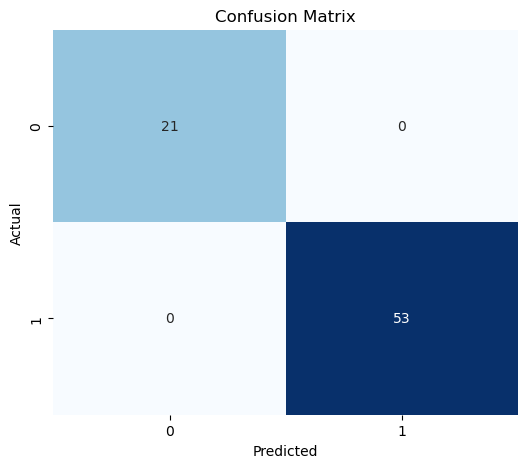

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the Excel file
file_path = "Submission_3_Main_v0.xlsx"
df = pd.read_excel(file_path)

# Separate features and target variable
X = df.drop(columns=["ID", "Country"])
y = df["ID"]

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the SVM classifier (RBF kernel)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_scaled, y)

# Predict on the same dataset
y_pred = svm_model.predict(X_scaled)

# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))

# Optional: check feature importance via coefficients (for linear kernel)
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_scaled, y)
importance = abs(svm_linear.coef_[0])
feature_importance = pd.DataFrame({
    'Feature': df.columns[2:],  # skip ID and Country
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Linear SVM):\n", feature_importance)


cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



C:\Users\orhan\AppData\Local\Temp\ipykernel_52944\1580634870.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


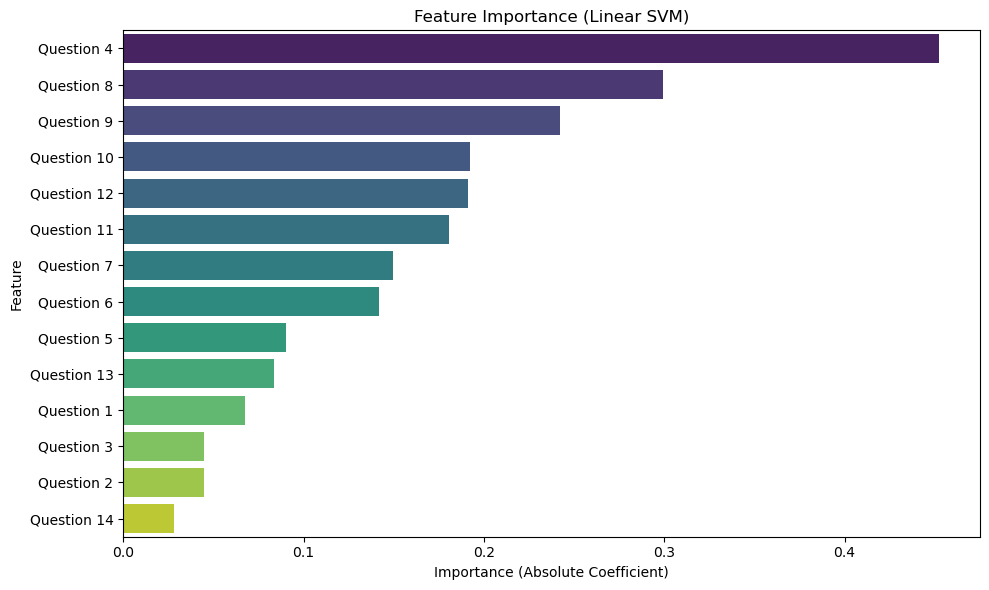

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Linear SVM)')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


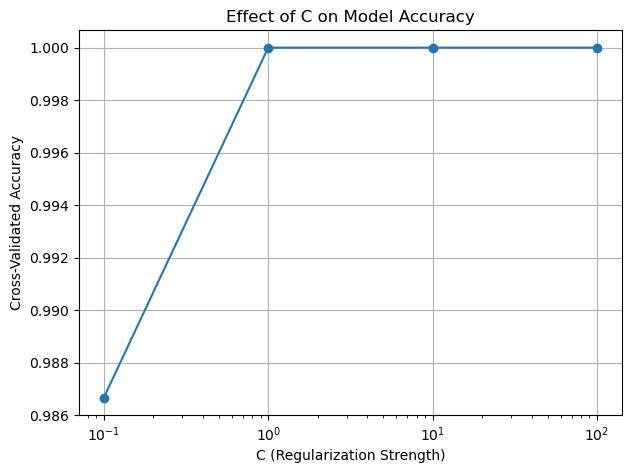

In [10]:
from sklearn.model_selection import cross_val_score

C_values = [0.1, 1, 10, 100]
accuracies = []

for c in C_values:
    model = SVC(kernel='rbf', C=c, gamma='scale', random_state=42)
    scores = cross_val_score(model, X_scaled, y, cv=5)
    accuracies.append(scores.mean())

plt.figure(figsize=(7, 5))
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')
plt.title('Effect of C on Model Accuracy')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.show()


# H. Expected Value

In [11]:
from scipy.stats import ttest_rel, wilcoxon

# -------------------------------------------------
# 1. Load Excel
# -------------------------------------------------
xlsx_path = "Submission_3_Main_v0.xlsx"
raw = pd.read_excel(xlsx_path,sheet_name = "Expected Values")

# -------------------------------------------------
# 2. Reshape to tidy format
# -------------------------------------------------
df = (
    raw
    .set_index("Questions")   # Humans / LLMs / Expected Value
    .T                        # questions become rows
    .reset_index()
    .rename(columns={
        "index": "Question",
        "Expected Value": "ExpectedValue"
    })
)

# Ensure numeric
df["Question"] = pd.to_numeric(df["Question"], errors="coerce")

for col in ["Humans", "LLMs", "ExpectedValue"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna()

# -------------------------------------------------
# 3. Compute deviations
# -------------------------------------------------
df["Dev_Humans"] = (df["Humans"] - df["ExpectedValue"]).abs() / df["ExpectedValue"]
df["Dev_LLMs"] = (df["LLMs"] - df["ExpectedValue"]).abs() / df["ExpectedValue"]

# -------------------------------------------------
# 4. Output table
# -------------------------------------------------
print("\nDeviation by question:")
print(df[["Question", "Dev_Humans", "Dev_LLMs"]])

print("\nMean deviation:")
print("Humans:", df["Dev_Humans"].mean())
print("LLMs:", df["Dev_LLMs"].mean())

# -------------------------------------------------
# 5. Statistical tests (paired)
# -------------------------------------------------
t_stat, t_pval = ttest_rel(df["Dev_Humans"], df["Dev_LLMs"])
w_stat, w_pval = wilcoxon(df["Dev_Humans"], df["Dev_LLMs"])

print("\nPaired t-test:")
print(f"t = {t_stat:.4f}, p = {t_pval:.4g}")

print("\nWilcoxon signed-rank test:")
print(f"W = {w_stat:.4f}, p = {w_pval:.4g}")



Deviation by question:
Questions  Question  Dev_Humans  Dev_LLMs
0                 5    0.589011  0.183516
1                 6    0.641667  0.101667
2                 7    0.592222  0.126667
3                 8    0.911617  0.061000
4                 9    0.410000  0.200000
5                10    0.784167  0.262917
6                11    0.406250  0.008333
7                12    0.430000  0.013333

Mean deviation:
Humans: 0.5956166514041514
LLMs: 0.11967914377289378

Paired t-test:
t = 7.3954, p = 0.00015

Wilcoxon signed-rank test:
W = 0.0000, p = 0.007812
